In [1]:
import pandas as pd
import numpy as np
from twarc import Twarc
import constants as cnst
from newspaper import Article, ArticleException
from tqdm import tqdm
import string
import matplotlib.pylab as plt


In [2]:
primary = pd.read_csv('./retweet_main.csv', na_values=-1)
secondary = pd.read_csv('./retweet_secondary.csv', na_values=-1)
t = Twarc(cnst.consumer_key, cnst.consumer_secret,cnst.access_token, cnst.access_token_secret)

Identify unpopulated columns

In [3]:
columns = {str(i) for i in range(1,101)}
unpop_primary = set()
unpop_secondary = set()
for col in columns:
    if (primary[col].isna()).all():
        unpop_primary.add(col)
    if (secondary[col].isna()).all():
        unpop_secondary.add(col)
# print(unpop_primary)
# print(unpop_secondary)
unpop_union = unpop_primary |unpop_secondary
pop_cols = columns.difference(unpop_union)

Removing unpopulated columns

In [4]:
primary = primary[set(primary.columns).difference(unpop_union)]
print(primary.columns)
secondary = secondary[set(secondary.columns).difference(unpop_union)]
print(secondary.columns)

Index(['1', 'count', 'created_time', '9', '4', '2', '6', '8', 'next_update',
       'tweet_id', '10', '7', '5', '11', '3'],
      dtype='object')
Index(['1', 'count', 'created_time', '9', '4', '2', '6', '8', 'next_update',
       'tweet_id', '10', '7', '5', '11', '3'],
      dtype='object')


## Stats 1 :  Tweets per day

In [5]:
primary_stats = {}
secondary_stats = {}
for col in pop_cols:
    if col in primary:
        primary_stats[int(col)] = len(primary.loc[primary[col].notna()])
        secondary_stats[int(col)] = len(secondary.loc[secondary[col].notna()])

[(1, 14521), (2, 12855), (3, 11166), (4, 9642), (5, 8652), (6, 7543), (7, 5846), (8, 4066), (9, 2377), (10, 1120), (11, 189)]
[(1, 14343), (2, 12308), (3, 10614), (4, 9014), (5, 8001), (6, 7300), (7, 6071), (8, 4333), (9, 2666), (10, 1291), (11, 177)]


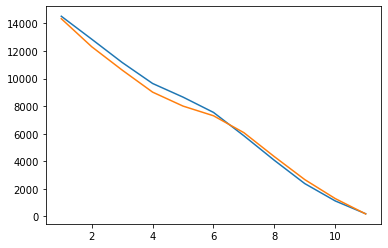

In [6]:
for stat_list in (primary_stats,secondary_stats):
    print(sorted(stat_list.items()))
    lists = sorted(stat_list.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y)
plt.show()

## Removing columns

### Setting column counts

In [7]:
column_count = 7

In [8]:
valid_columns = ["tweet_id","created_time","count"]+[str(i) for i in range(1, column_count)]
primary = primary.loc[primary['count'] >= column_count, valid_columns]
secondary = secondary.loc[secondary['count'] >= column_count, valid_columns]

Dropping rows with na

In [9]:
primary = primary.dropna()
secondary = secondary.dropna()

## Stats 2 : Difference

In [10]:
intersec_ids = set(secondary['tweet_id']).intersection(set(primary['tweet_id']))
diff_pri = set(primary['tweet_id']).difference(set(secondary['tweet_id']))
diff_sec = set(secondary['tweet_id']).difference(set(primary['tweet_id']))
len(intersec_ids),len(diff_pri),len(diff_sec)

(5716, 1827, 373)

In [11]:
df = primary.loc[primary['tweet_id'].isin(intersec_ids)].copy()
df = df.append(primary.loc[primary['tweet_id'].isin(diff_pri)])
df = df.append(secondary.loc[secondary['tweet_id'].isin(diff_sec)])

In [12]:
df = df.reset_index().drop('index', axis=1)

In [13]:
df['user_id'] = np.nan
df['screen_name'] = np.nan
df['url'] = np.nan
df['follower_count'] = np.nan
df['title'] = np.nan
df['content'] = np.nan
df['author'] = np.nan
df['published_data'] = np.nan

In [14]:
not_found = list()
for tweet in tqdm(t.hydrate(intersec_ids | diff_pri | diff_sec),total=len(intersec_ids | diff_pri | diff_sec)) :   
    df.loc[(df.tweet_id == tweet["id"]), "user_id"] = tweet["user"]["id"]
    df.loc[(df.tweet_id == tweet["id"]), "screen_name"] = tweet["user"]["name"]
    df.loc[(df.tweet_id == tweet["id"]), "follower_count"] = tweet["user"]["followers_count"]
    try:
        df.loc[(df.tweet_id == tweet["id"]), "url"] = tweet["entities"]["urls"][0]["expanded_url"]
    except:
        not_found.append(tweet["id"])
len(not_found)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7916/7916 [01:16<00:00, 103.71it/s]


365

In [15]:
# df.to_csv("./partial.csv")

In [16]:
df = df.dropna(subset=['url'])
df

,tweet_id,created_time,count,1,2,3,4,5,6,user_id,screen_name,url,follower_count,title,content,author,published_data
0,1272217655630458881,2020-06-14 17:21:40+00:00,12,454,463.0,462.0,464.0,464.0,466.0,16664681.0,Los Angeles Times,https://lat.ms/3hro9wq,3633869.0,NaN,NaN,NaN,NaN
1,1272216897237516289,2020-06-14 17:18:39+00:00,12,163,163.0,163.0,163.0,162.0,162.0,28785486.0,ABC News,https://abcn.ws/2UGkIrQ,15735133.0,NaN,NaN,NaN,NaN
2,1272220034065186817,2020-06-14 17:31:07+00:00,12,910,927.0,929.0,933.0,934.0,936.0,759251.0,CNN,https://cnn.it/3d4Az9Y,48809294.0,NaN,NaN,NaN,NaN
3,1272219784743202816,2020-06-14 17:30:08+00:00,12,2352,2377.0,2381.0,2378.0,2376.0,2373.0,807095.0,The New York Times,https://nyti.ms/2YDi6vY,46858869.0,NaN,NaN,NaN,NaN
4,1272220746014572545,2020-06-14 17:33:57+00:00,12,241,267.0,267.0,267.0,267.0,267.0,16664681.0,Los Angeles Times,https://www.latimes.com/california/story/2020-...,3633869.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7911,1274241839852290048,2020-06-20 07:25:03+00:00,7,46,46.0,46.0,46.0,46.0,46.0,1652541.0,Reuters,https://reut.rs/2zMexez,22071108.0,NaN,NaN,NaN,NaN
7912,1274243117902856192,2020-06-20 07:30:08+00:00,7,44,46.0,48.0,50.0,50.0,49.0,3108351.0,The Wall Street Journal,https://on.wsj.com/3hNWAxl,17861980.0,NaN,NaN,NaN,NaN
7913,1274243372828569601,2020-06-20 07:31:09+00:00,7,98,102.0,101.0,99.0,95.0,97.0,759251.0,CNN,https://cnn.it/2NdvWjt,48809287.0,NaN,NaN,NaN,NaN
7914,1274243580563988481,2020-06-20 07:31:58+00:00,7,22,22.0,23.0,23.0,21.0,22.0,14293310.0,TIME,https://ti.me/3dbSNq3,17288080.0,NaN,NaN,NaN,NaN


In [ ]:
not_parsed = set()
for idx, row in tqdm(df.iterrows(), total=len(df)):
#     row = uci.loc[idx]  
    article = Article(row.url)
    article.download()
    try:
        article.parse()
        df.loc[df.url == row.url, 'title']=article.title.replace("|", " ")
        df.loc[df.url == row.url, 'content']=article.text.replace("|", " ")
        df.loc[df.url == row.url, 'author']=",".join(article.authors)
        df.loc[df.url == row.url, 'published_data']=article.publish_date
        if idx%100 == 0 and idx != 0:
            df[:idx].to_csv("./Organic_extended1_{}.csv".format(idx), sep="|")
#             break
    except ArticleException as e:
        not_parsed.add(row['url'])
#         print(str(e))
#         print(row['url'])
df.to_csv("./Organic_extended.csv")        
print(not_parsed)

  4%|████▊                                                                                                            | 325/7551 [04:12<1:08:45,  1.75it/s]

## Cleaning based on title len

In [ ]:
dataframe = pd.read_csv("./Organic_extended.csv", sep="|") 

In [ ]:
dataframe['title_len'] = dataframe['title'].str.len()
dataframe['content_len'] = dataframe['content'].str.len()
# length = dataframe['content'].str.len()
# length.min(), length.max(), length.mean()

In [ ]:
print(dataframe['title_len'].aggregate([np.mean, np.min, np.max]))
dataframe['title_len'].plot.hist(bins=500)

In [ ]:
print(dataframe.loc[dataframe['title_len']>=68, ['tweet_id','title']])

In [ ]:
print(dataframe['content_len'].aggregate([np.mean, np.min, np.max]))
dataframe['content_len'].plot.hist(bins=500)

In [ ]:
dataframe['']